In [1]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import torch
import torch.nn as nn
import dynamic_nn_pt as dynn

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


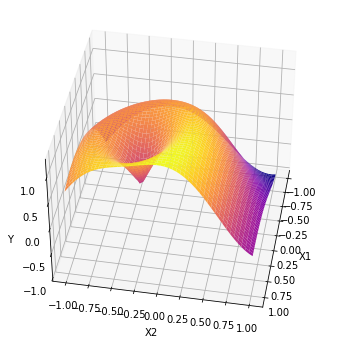

In [30]:
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
X2 = np.linspace(-2, 4, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1 + (X1+X2)/3

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))

%matplotlib inline
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
ax.view_init(elev=40., azim=10)

ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')

plt.savefig("./reg_toy_data.pdf", bbox_inches='tight')
plt.show()

In [4]:
dynet = dynn.Dynamic_Network(2, 1, num_stat=5, num_std=250, decay_rate_std=0.03)
criterion = nn.MSELoss()

In [5]:
### hyperparameters
num_add_neuron = 5
num_decay_steps = 1000
threshold_max = 0.1
threshold_min = 0.001
learning_rate = 0.01

train_step_min = 700
train_step_max = 7000

In [6]:
dynet.tree.add_to_remove_ratio = 2.

### when to stop training functionality

In [7]:
def update_coeff(num_iter=5, lr=0.9):
    if len(loss_list)<10: return np.array([0]), np.array([0]), float(coeff.data[0])
    
    _t = torch.tensor(loss_list)
    _t = (_t - _t[-1])/(_t[0]-_t.min()) ## normalize to make first point at 1 and last at 0 
    _t = torch.clamp(_t, -1.1, 1.1)
    _x = torch.linspace(0, 1, steps=len(_t))
    
    for _ in range(num_iter):
        coeff_opt.zero_grad()
        _y = torch.exp(coeff*_x)*(1.00001-_x)*coeff1 + coeff2

        _loss = ((_y - _t)**2).mean()
        if loss>10.:
            print("Loss too high")
            continue
        _loss.backward()
        coeff_opt.step()

        coeff.data = torch.clamp(coeff.data, -20., 20.)
        coeff1.data = torch.clamp(coeff1.data, 0.7, 2.)
        coeff2.data = torch.clamp(coeff2.data, -0.2,0.1)
        
    _y = torch.exp(coeff*_x)*(1-_x)*coeff1 + coeff2

    return _x.numpy(), _t.numpy(), _y.data.numpy()

## Train Network dynamically

### Start

In [119]:
dynet.add_neurons(num_add_neuron)

In [120]:
dynet.print_network()

2
└────┐
     └────┐
          ├────┐
          │    2
          ├────┘
          5
          └────┐
               ├────┐
               │    1
               ├────┘
               5
          ┌────┘
     ┌────┘
     3
     └────┐
          ├────┐
          │    3
          ├────┘
          4
     ┌────┘
┌────┘
│
1


In [121]:
optimizer = torch.optim.Adam(dynet.parameters(), lr=learning_rate)

coeff = torch.zeros(1, requires_grad=True)
coeff1 = torch.zeros(1, requires_grad=True)
coeff2 = torch.zeros(1, requires_grad=True)
coeff_opt = torch.optim.Adam([coeff, coeff1, coeff2], lr=1)
loss_list = []

### Training Step

In [ ]:
%matplotlib tk
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122)

for epoch in range(train_step_max):

    dynet.decay_neuron_step()
    dynet.tree.std_loss = 0.    

    yout = dynet(xx)
    loss = criterion(yout, yy) + dynet.tree.decay_rate_std*dynet.tree.std_loss
    
    if epoch>100:
        loss_list.append(float(loss))
    
    optimizer.zero_grad()
    loss.backward(retain_graph=False)
    optimizer.step()
    
    if epoch%100 == 0:
        _x, _t, _y = update_coeff(50)
        _c = float(coeff.data[0])

        print(f'Epoch: {epoch}, Loss:{float(loss)}, coeff:{_c}')
        ax.clear()

        ax.scatter(X1, X2, Y, marker= '.')
        ax.scatter(X1, X2, yout.data.numpy().reshape(-1), color='r', marker='.')
        
        ax2.clear()
        if len(_x)>0:
            ax2.plot(_x, _y, c='m')
            ax2.plot(_x, _t, c='c')

        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        
        if _c < -5 and epoch>train_step_min: break

plt.close()

Epoch: 0, Loss:0.0071518621407449245, coeff:-1.1486705541610718


Epoch: 100, Loss:0.006880066357553005, coeff:-1.2232627868652344


Epoch: 200, Loss:0.006468139588832855, coeff:1.4610803127288818


Epoch: 300, Loss:0.006063050590455532, coeff:1.0193870067596436


Epoch: 400, Loss:0.0055050915107131, coeff:0.37565499544143677


Epoch: 500, Loss:0.004746300633996725, coeff:1.0749908685684204


Epoch: 600, Loss:0.004499936476349831, coeff:1.0916184186935425


Epoch: 700, Loss:0.004266742616891861, coeff:0.9380528330802917


Epoch: 800, Loss:0.004237546119838953, coeff:0.768063485622406


Epoch: 900, Loss:0.0038111768662929535, coeff:0.6338260769844055


Epoch: 1000, Loss:0.003823863808065653, coeff:0.5031324028968811


Epoch: 1100, Loss:0.003491787938401103, coeff:0.39913952350616455


Epoch: 1200, Loss:0.0034619898069649935, coeff:0.279094934463501


Epoch: 1300, Loss:0.0032507223077118397, coeff:0.1538761705160141


Epoch: 1400, Loss:0.0032293773256242275, coeff:0.02388584427535534


E

In [ ]:
coeff, coeff1, coeff2

In [ ]:
loss

In [ ]:
dynet.print_network_debug()

## Compute Significance

In [113]:
dynet.start_computing_significance()

for epoch in range(1):
    yout = dynet(xx)
    yout.backward(gradient=torch.ones_like(yout))
    optimizer.zero_grad()

dynet.finish_computing_significance()

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


#### start removing less significant neurons

In [114]:
dynet.identify_removable_neurons(num=None,
                                 threshold_min = threshold_min,
                                 threshold_max = threshold_max)

(tensor(0.0001),
 tensor([2.9461e-01, 2.0219e+00, 0.0000e+00, 8.2547e-01, 1.1427e-01, 0.0000e+00,
         1.0019e+00, 6.3887e+00, 8.6648e-01, 1.2697e+00, 5.3503e-01, 1.1357e+00,
         2.0447e+00, 2.4730e-01, 1.4131e+00, 1.3416e+00, 6.5454e-02, 3.0504e-01,
         1.3491e-01, 7.7823e-02, 1.4783e-04]))

In [115]:
dynet.decay_neuron_start(decay_steps=num_decay_steps)

3

In [116]:
# num_decay_steps

## Actual Removing

In [117]:
%matplotlib tk
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection='3d')

for epoch in range(num_decay_steps+5):

    dynet.decay_neuron_step()
    dynet.tree.std_loss = 0.    

    yout = dynet(xx)
    loss = criterion(yout, yy) + dynet.tree.decay_rate_std*dynet.tree.std_loss
    
    optimizer.zero_grad()
    loss.backward(retain_graph=False)
    optimizer.step()
    
    if epoch%100 == 0:
        print(f'Epoch: {epoch}, Loss:{float(loss)}')
        ax.clear()

        ax.scatter(X1, X2, Y, marker= '.')
        ax.scatter(X1, X2, yout.data.numpy().reshape(-1), color='r', marker='.')

        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        
plt.close()

Epoch: 0, Loss:0.007340525276958942


Epoch: 100, Loss:0.00754591403529048


Epoch: 200, Loss:0.007663009688258171


Epoch: 300, Loss:0.007584996055811644


Epoch: 400, Loss:0.008062385022640228


Epoch: 500, Loss:0.007911788299679756


Epoch: 600, Loss:0.008162345737218857


Epoch: 700, Loss:0.008130393922328949


Epoch: 800, Loss:0.008568924851715565


Epoch: 900, Loss:0.008414587937295437


Epoch: 1000, Loss:0.007348519749939442




In [118]:
dynet.print_network()

2
└────┐
     └────┐
          ├────┐
          │    2
          ├────┘
          4
          └────┐
               ├────┐
               │    0
               ├────┘
               5
          ┌────┘
     ┌────┘
     2
     └────┐
          ├────┐
          │    2
          ├────┘
          3
     ┌────┘
┌────┘
│
1


#### compute del_neuron statstics after removing neurons

In [102]:
dynet.compute_del_neurons()

## Maintain Structure of Network

In [103]:
dynet.maintain_network()

In [104]:
len(dynet.tree.DYNAMIC_LIST)

8

## Repeat from start

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  This is separate from the ipykernel package so we can avoid doing imports until


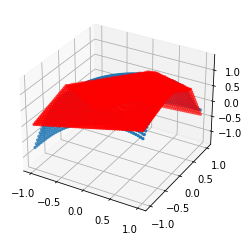

In [22]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')

yout = dynet(xx)
ax.scatter(X1, X2, Y, marker= '.')
ax.scatter(X1, X2, yout.data.numpy().reshape(-1), color='r', marker='.')